# Нейро-нечеткие системы
## Лабораторная работа №1

### Кластеризация, снижение размерности пространства признаков

Для выбранного набора данных необходимо провести кластеризацию при помощи метода k-средних (или альтернативного из той же группы) и метода DBSCAN (или альтернативного из той же группы). Для метода из первой группы необходимо выбрать количество кластеров с использованием одного из методов (метод локтя, индекс Дана, индекс Дэвиса-Болдуина, индекс Калинского-Гарабача, метод силуэта, RAND - обязателен при наличии целевой переменной). Для методов из второй группы необходимо выбрать $ε$ и другие параметры метода.

Требуется сравнить визуализацию данных с использованием методов PCA, MDS (или альтернативного из той же группы, один метод на выбор) с t-SNE, UMAP (или альтернативного из той же группы, один метод на выбор) с разметкой по полученным кластерам.


### Набор данных
Student Alcohol Consumption (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)

- school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
- sex - student's sex (binary: 'F' - female or 'M' - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: 'U' - urban or 'R' - rural)
- famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
- Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
- Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
- guardian - student's guardian (nominal: 'mother', 'father' or 'other')
- traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)

These grades are related with the course subject, Math or Portuguese:

- G1 - first period grade (numeric: from 0 to 20)
- G2 - second period grade (numeric: from 0 to 20)
- G3 - final grade (numeric: from 0 to 20, output target)

### Практическая часть

In [65]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from umap import umap_ as UMAP
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

Из предметов мне было интересно посмотреть про математику, но можно добавить и португальский (расскоментировать код ниже), к тому же DBSCAN тогда не сможет кластеризовать данные.

In [66]:
# student_por = pd.read_csv('data/student-por.csv')
student_mat = pd.read_csv('data/student-mat.csv')
# df=pd.concat([student_por, student_mat],axis=0)
df = student_mat

1. В ML многие алгоритмы работают только с числовыми данными, поэтому необходимо преобразовывать категориальные признаки перед их использованием.

In [67]:
# Кодирование категориальных признаков
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

2. Нормализуем данные перед кластеризацией т.к KMeans и DBSCAN, основаны на измерении расстояний между точками в пространстве признаков. Т.е если признаки имеют разный масштаб, то их вклад в измерение расстояний может быть неодинаковым, что может привести к некорректной кластеризации. 

In [68]:
# Нормализация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

3. Теперь определим оптимальное количество кластеров с помощью метода силуэта и выполним кластеризацию с помощью метода k-средних:

Для метода k-средних количество кластеров выбирается с помощью метода силуэта
График силуэта имеет пиковый характер, в отличие от мягко изогнутого графика при использовании метода локтя.
Его проще визуализировать и обосновать.


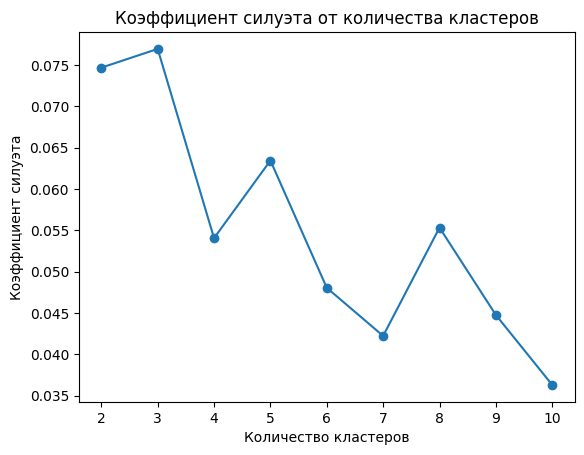

Среднее значение силуэта изначально высокое до k=3, а затем резко снижается для более высоких значений k. То есть мы получаем выраженный пик при k=3, это количество кластеров, сгенерированных в исходном датасете.


In [69]:
print("Для метода k-средних количество кластеров выбирается с помощью метода силуэта")
print("График силуэта имеет пиковый характер, в отличие от мягко изогнутого графика при использовании метода локтя.")
print("Его проще визуализировать и обосновать.")

silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, labels))

# Вывод графика
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта от количества кластеров')
plt.show()


# Выбор оптимального количества кластеров и выполнение кластеризации
optimal_k = k_values[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k)
kmeans_labels = kmeans.fit_predict(data_scaled)

print(f"Среднее значение силуэта изначально высокое до k={optimal_k}, а затем резко снижается для более высоких значений k. То есть мы получаем выраженный пик при k={optimal_k}, это количество кластеров, сгенерированных в исходном датасете.")

4. Выполним кластеризацию с помощью метода DBSCAN

In [70]:
# попробовал несколько значений эпсилон, выбрал это
eps_value = 4.76
dbscan = DBSCAN(eps=eps_value, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

print(f"Значение эпсилон для DBSCAN:  {eps_value}")

Значение эпсилон для DBSCAN:  4.76


5. Далее применим методы снижения размерности (PCA, MDS, t-SNE, UMAP)

In [71]:
pca = PCA(n_components=3)
mds = MDS(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP.UMAP(n_components=2)

pca_data = pca.fit_transform(data_scaled)
mds_data = mds.fit_transform(data_scaled)
tsne_data = tsne.fit_transform(data_scaled)
umap_data = umap.fit_transform(data_scaled)

ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

In [ ]:
def plot_clusters(X, labels, title, ax, color_map):
    for label in np.unique(labels):
        color = color_map[label]
        ax.scatter(X[labels == label, 0], X[labels == label, 1], c=color, alpha=0.5)
    ax.set_title(title)

6. Визуализируем результаты кластеризации

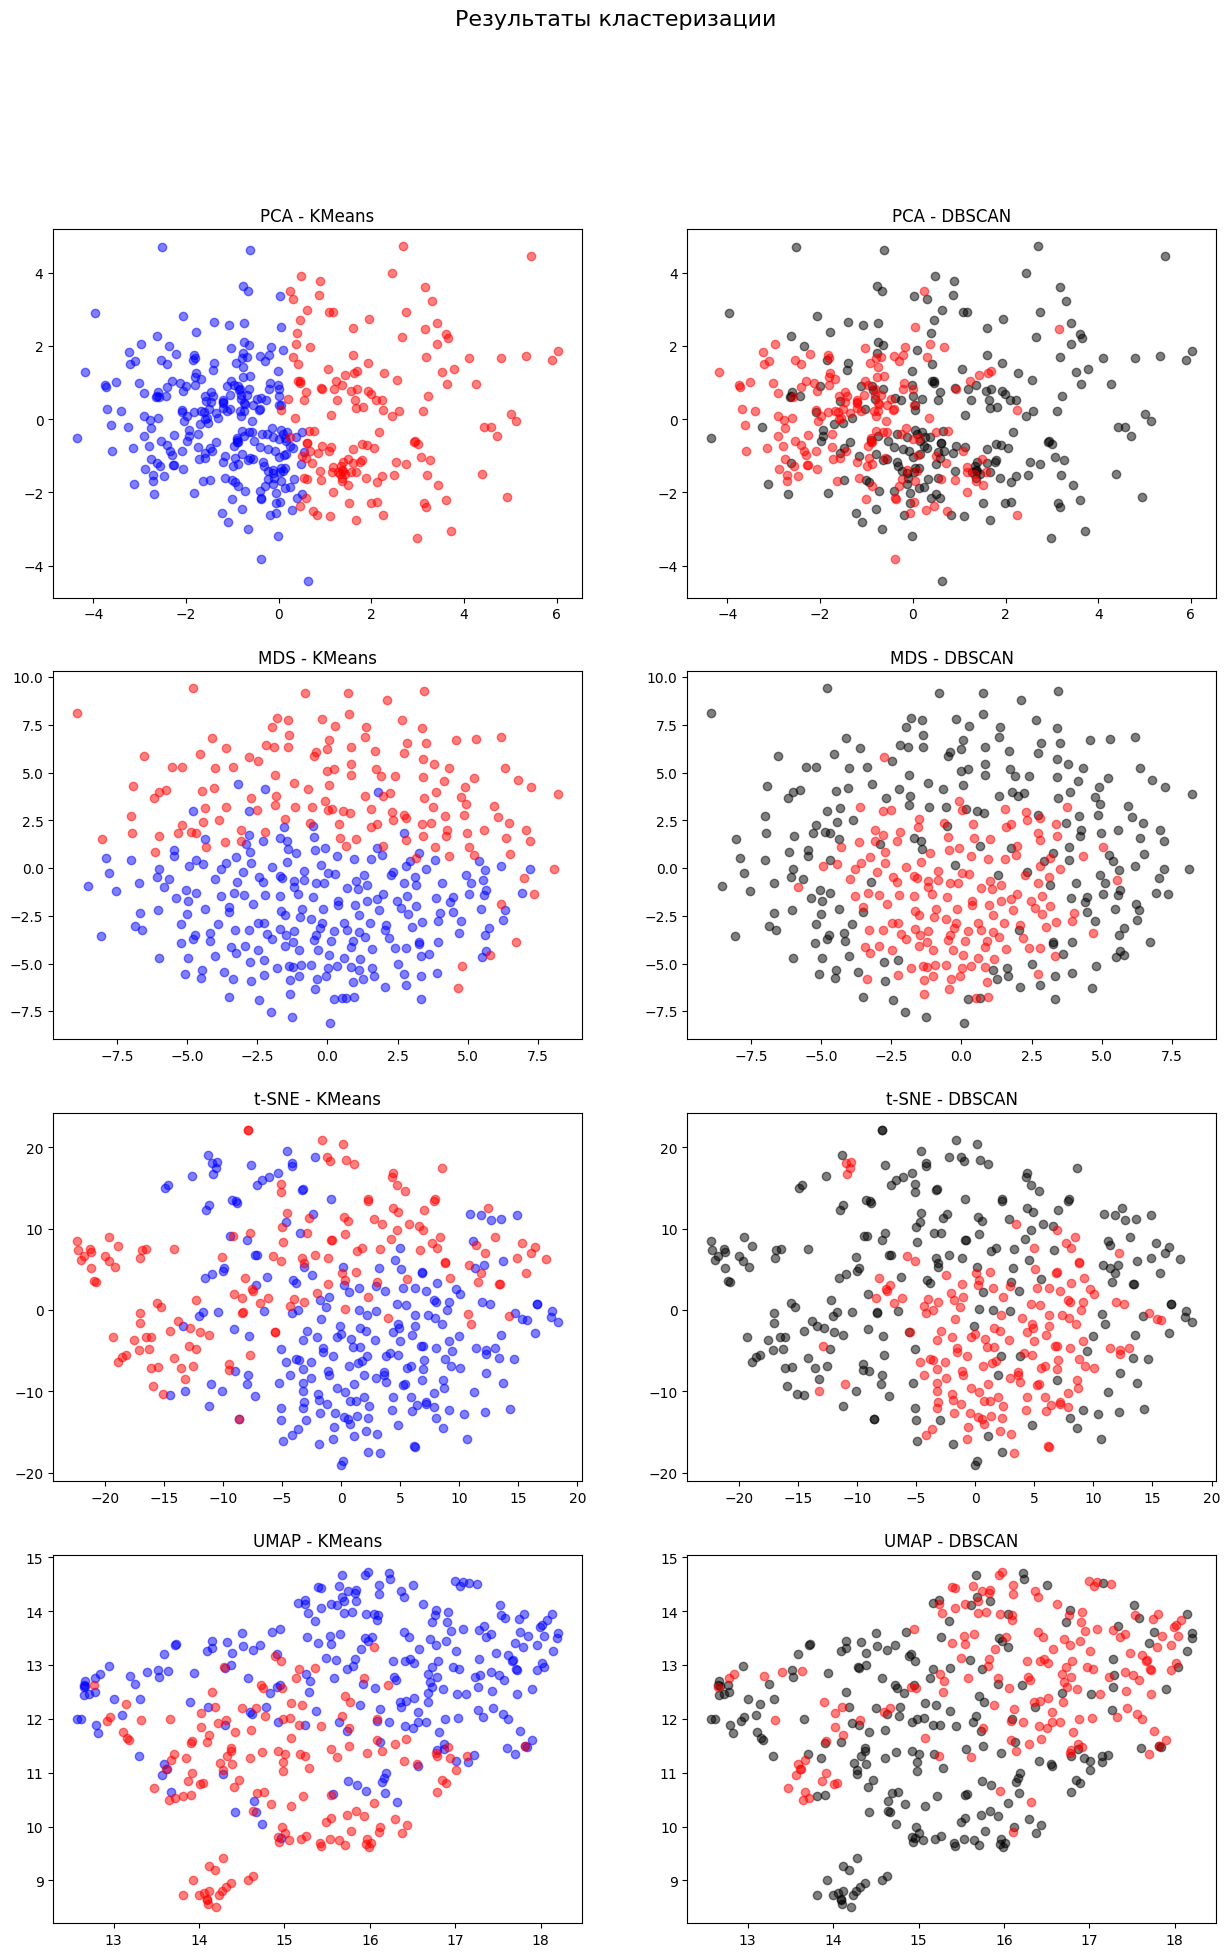

In [ ]:
kmeans_color_map = {0: 'b', 1: 'r', 2: 'g', 3: 'c', 4: 'm', 5: 'y', 6: 'k', -1: 'k'}
dbscan_color_map = {-1: 'k', 0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k'}

fig, axes = plt.subplots(4, 2, figsize=(15, 22))
fig.suptitle('Результаты кластеризации', fontsize=16)
plot_clusters(pca_data, kmeans_labels, 'PCA - KMeans', axes[0, 0], kmeans_color_map)
plot_clusters(pca_data, dbscan_labels, 'PCA - DBSCAN', axes[0, 1], dbscan_color_map)
plot_clusters(mds_data, kmeans_labels, 'MDS - KMeans', axes[1, 0], kmeans_color_map)
plot_clusters(mds_data, dbscan_labels, 'MDS - DBSCAN', axes[1, 1], dbscan_color_map)
plot_clusters(tsne_data, kmeans_labels, 't-SNE - KMeans', axes[2, 0], kmeans_color_map)
plot_clusters(tsne_data, dbscan_labels, 't-SNE - DBSCAN', axes[2, 1], dbscan_color_map)
plot_clusters(umap_data, kmeans_labels, 'UMAP - KMeans', axes[3, 0], kmeans_color_map)
plot_clusters(umap_data, dbscan_labels, 'UMAP - DBSCAN', axes[3, 1], dbscan_color_map)

plt.show()